# 摘要

# 理论模型

股票价格在通常情况下是服从几何随机游走的，但在特殊的条件或者时段会表现出均值回归现象。

\cite{Chan:2013} 中给出的缺口买入策略（Buy-on-Gap）为：
1. 在市场开盘时，选择开盘价相对上一个交易日最低价的收益率低于收益率一个标准差的股票，收益率的标准差可以用过去一段时间的收益率数据来估计，比如 90 天。这些股票被认为是向下跳空（Gapped Down）。
2. 为了进一步减少买入的股票数量，可以添加一个动量过滤器（Momentum Filter），比如要求开盘价仍然要高于过去收盘价的移动平均线，即要求股票处于一个上涨趋势中，向下的跳空并未破坏趋势，否则这种大幅跳空可能是反映了一些负面消息而产生的实质性下跌，这种下跌很难回复。
3. 如果有买入数量的限制，可以买入开盘价相对昨日最低价收益率最低的前 N 只（比如 10 只，前两个步骤筛选后的数目小于 N 则全部买入）股票。
4. 在市场收盘时清空所有仓位。

该策略的一个支持逻辑是：当指数期货在股票市场开盘前下跌，某些股票会因为恐慌性抛售而大幅下跌，而一旦恐慌性的抛售结束，股票会在当天剩下的时间里恢复性上涨。另外，步骤 2 里要求的股票位于一个长期均线之上会吸引一些交易周期较长的机构投资者卖出，在开盘时这种对于流动性的需求会加重股票向下的压力，股票价格源于流动性需求的变动相比于源于基本面的变动更倾向于回复，从而该策略可能在消息频繁释放的时段依然有效，而这些时段传统的均值回归策略普遍会失效。

同样可以反向操作定义所谓的缺口卖出策略。但卖空可能存在某些限制，缺口卖出策略可能会相对难以操作。

另外，还可以同时进行缺口买入和缺口卖出策略，构造一个多空策略。还可以在缺口买入的同时做空股指期货来构造一个对冲策略。


# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
HDB = QS.FactorDB.HDF5DB()
HDB.connect();

In [2]:
# 参数设置和数据准备
StartDT = dt.datetime(2010, 4, 16)# 回测开始日期
EndDT = dt.datetime(2018, 11, 30)# 回测截止日期

FT = HDB.getTable("ElementaryFactor")
IDs = FT.getID(ifactor_name="复权收盘价")
DTs = FT.getDateTime(ifactor_name="复权收盘价", start_dt=StartDT, end_dt=EndDT)
Low = FT.readData(factor_names=["复权最低价"], ids=IDs, dts=DTs).iloc[0, :, :]
Open = FT.readData(factor_names=["复权开盘价"], ids=IDs, dts=DTs).iloc[0, :, :]
Close = FT.readData(factor_names=["复权收盘价"], ids=IDs, dts=DTs).iloc[0, :, :]
C2CReturn = FT.readData(factor_names=["日收益率"], ids=IDs, dts=DTs).iloc[0, :, :]
FT = HDB.getTable("IndexConstituentFactor")
IndexConstituent = FT.readData(factor_names=["中证500"], ids=IDs, dts=DTs).iloc[0, :, :]

,0
起始时点,2010-08-26 00:00:00
结束时点,2018-09-28 00:00:00
时点数,1969
总收益率,13.088
年化收益率,0.386454
年化波动率,0.261653
Sharpe比率,1.47697
胜率,0.920772
最大回撤率,0.269004
最大回撤开始时点,2017-01-11 00:00:00


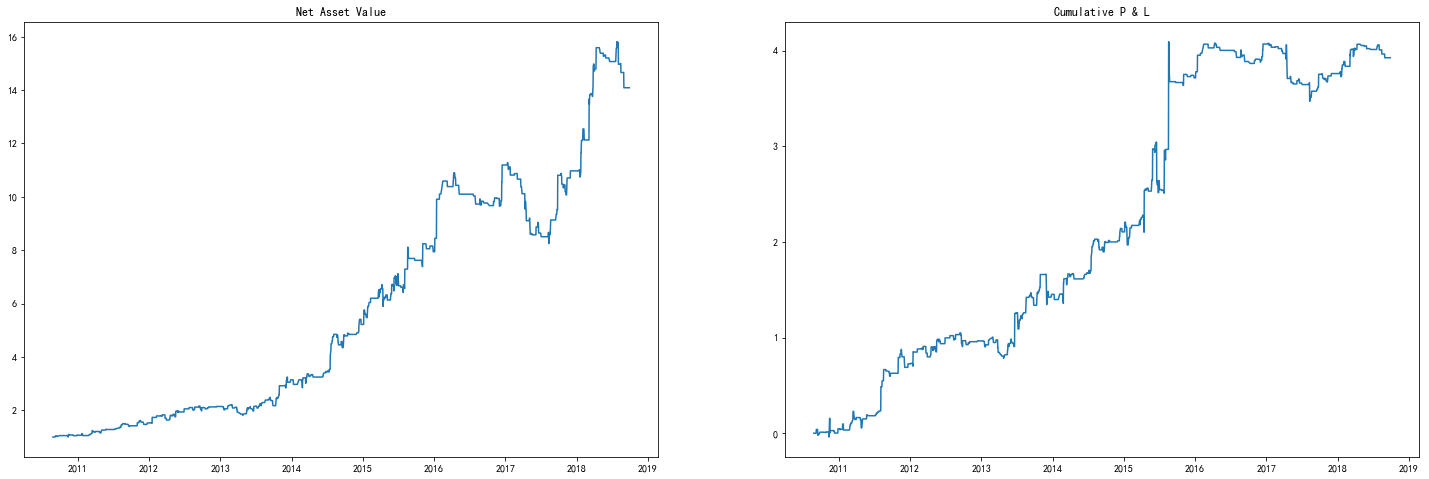

In [3]:
# 缺口买入策略
TopN = 10
StdLookBack = 90
EntryThreshold = 1
MALookBack = 20

BuyThreshold = (Low * (1 - EntryThreshold * C2CReturn.rolling(StdLookBack).std())).shift(1)
MA = Close.rolling(MALookBack).mean().shift(1)
RetGap = Open / Low.shift(1) - 1
Mask = ((Open < BuyThreshold) & (Open > MA) & (IndexConstituent==1))

MaxLookBack = max(StdLookBack, MALookBack)
Amount = pd.DataFrame(0.0, index=DTs[MaxLookBack:], columns=IDs)
for i, iDT in enumerate(tqdm_notebook(DTs[MaxLookBack:])):
    iRetGap = RetGap.iloc[i+MaxLookBack][Mask.iloc[i+MaxLookBack]]
    iIDs = iRetGap.sort_values(ascending=True).iloc[:TopN].index
    Amount.loc[iDT, iIDs] = 1.0

O2CReturn = Close / Open - 1
PNL = Amount * O2CReturn.iloc[MaxLookBack:, :]
Return = PNL.sum(axis=1) / Amount.sum(axis=1)
Return[pd.isnull(Return) | np.isinf(Return)] = 0
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.

